# Notebook on research put-call parity

In [287]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import seaborn as sns
import statsmodels.formula.api as sm
import plotly.graph_objects as go
import datetime
from utils import get_human_timestamp
import plotly
import plotly.graph_objs as go
import plotly.express as px
from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots


In [2]:
df = pd.read_csv(f"./datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
data = df.copy()

## Отбираем нужные колонки и опционы только на одну криптовалюту

In [91]:
def preprocess_data(df: pd.DataFrame, currency: str  = "BTC"):
    ind = [symbol.startswith(currency) for symbol in df.symbol]
    needed_columns = ["timestamp", "type", "strike_price", "expiration", "mark_price", "underlying_price"]
    data = df[ind].reset_index(drop=True)[needed_columns]
    data["human_expiration"] = data["expiration"].apply(get_human_timestamp)
    data["human_timestamp"] = data["timestamp"].apply(get_human_timestamp)
    return data

In [92]:
single_currency_chain = preprocess_data(data)

In [93]:
single_currency_chain

,timestamp,type,strike_price,expiration,mark_price,underlying_price,human_expiration,human_timestamp
0,1669852800273000,put,17250,1669881600000000,0.0095,17165.5125,2022-12-01 11:00:00.000000,2022-12-01 03:00:00.273000
1,1669852800273000,call,17500,1671177600000000,0.0377,17162.3600,2022-12-16 11:00:00.000000,2022-12-01 03:00:00.273000
2,1669852800302000,call,16500,1669881600000000,0.0393,17165.5125,2022-12-01 11:00:00.000000,2022-12-01 03:00:00.302000
3,1669852800324000,call,16500,1669881600000000,0.0393,17165.5125,2022-12-01 11:00:00.000000,2022-12-01 03:00:00.324000
4,1669852800402000,put,250000,1672387200000000,13.5643,17164.6600,2022-12-30 11:00:00.000000,2022-12-01 03:00:00.402000
...,...,...,...,...,...,...,...,...
10432075,1669939199983000,call,34000,1672387200000000,0.0004,16953.1600,2022-12-30 11:00:00.000000,2022-12-02 02:59:59.983000
10432076,1669939199983000,call,10000,1695974400000000,0.4728,16962.0900,2023-09-29 11:00:00.000000,2022-12-02 02:59:59.983000
10432077,1669939199984000,call,5000,1680249600000000,0.7089,16946.2200,2023-03-31 11:00:00.000000,2022-12-02 02:59:59.984000
10432078,1669939199988000,call,13500,1670572800000000,0.2059,16975.1700,2022-12-09 11:00:00.000000,2022-12-02 02:59:59.988000


In [153]:
def plot_single_expiration(df: pd.DataFrame, strike_given: int = False, expiration_date_given: int = False) -> None:
    # select options with similar expiration date
    single_expiration_date = df.sample(1).iloc[0]["expiration"]
    single_expiration_date_human = get_human_timestamp(single_expiration_date)
    single_expiration_date = expiration_date_given if expiration_date_given else single_expiration_date
    single_expiration_df = df[df["expiration"] == single_expiration_date].copy()
    
    # select options with similar strikes
    single_strike = single_expiration_df.sample(1).iloc[0]["strike_price"]
    single_strike = strike_given if strike_given else single_strike
    single_strike_df = single_expiration_df[single_expiration_df["strike_price"] == single_strike].copy()
    
    #divide by calls and puts and merge
    calls = single_strike_df[single_strike_df["type"] == "call"]
    calls["call_price_usd"] = calls["underlying_price"]*calls["mark_price"]
    puts = single_strike_df[single_strike_df["type"] == "put"]
    puts["put_price_usd"] = puts["underlying_price"]*puts["mark_price"]
    calls = calls.rename(columns = {"mark_price": "call_price"})[["timestamp", "call_price", 
        "strike_price", "underlying_price", "human_timestamp", "call_price_usd"]].copy()
    puts = puts.rename(columns = {"mark_price": "put_price"})[["timestamp", "put_price", "put_price_usd"]].copy()
    result = calls.merge(puts, on = "timestamp")
    result["parity"] = result["underlying_price"] - result["call_price_usd"] + result["put_price_usd"]
    
    # plotting
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["call_price_usd"], name='call price, usd'))
    fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["put_price_usd"], name='put price, usd'))
    fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["underlying_price"], name='underlying price, usd'))
    fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["parity"], name='parity'))
    # fig.add_trace(go.Scatter(x=result["human_timestamp"], y=result["strike_price"], name='strike'))
    fig.update_layout(title=f"Strike: {single_strike} USD, expiration: {single_expiration_date_human}")
    fig.show()
    
    return result


In [261]:
final_df = plot_single_expiration(single_currency_chain)

In [155]:
# fixed date and strike
final_df = plot_single_expiration(single_currency_chain, strike_given=10000, expiration_date_given = 1695974400000000)

## Dependency $call - put ~ \beta(f - S) + \alpha$

In [367]:
data.timestamp.value_counts()

1669852829604000    167
1669879352721000    156
1669866179901000    156
1669879113049000    154
1669878167200000    152
                   ... 
1669892977464000      1
1669892977503000      1
1669892977526000      1
1669892977556000      1
1669939199988000      1
Name: timestamp, Length: 5823203, dtype: int64

In [374]:
tick_all_options = data[data["timestamp"] == 1669879352721000]

# tick_all_options = data[data["timestamp"] == 1669852829604000]
# tick_all_options = data[data["timestamp"] == 1669852829604000]
# tick_all_options = data[data["timestamp"] == 1669852829604000]


tick_all_options = tick_all_options.drop(columns = ["local_timestamp"]).drop_duplicates()
tick_all_options = tick_all_options[tick_all_options["expiration"] == tick_all_options.sample(1).expiration.iloc[0]]
calls = tick_all_options[tick_all_options["type"] == "call"][["underlying_price", "strike_price", "mark_price"]]
puts = tick_all_options[tick_all_options["type"] == "put"][["strike_price", "mark_price"]]
calls = calls.rename(columns = {"mark_price": "call_price"})
puts = puts.rename(columns = {"mark_price": "put_price"})
result = calls.merge(puts, on = "strike_price")
result["call_price"] = result["call_price"]*result["underlying_price"]
result["put_price"] = result["put_price"]*result["underlying_price"]
result

,underlying_price,strike_price,call_price,put_price
0,17088.17,25000,29.049889,7940.872599
1,17088.17,5000,12108.677262,20.505804
2,17088.17,24000,39.302791,6949.758739
3,17088.17,55000,0.000000,37911.813962
4,17088.17,20000,217.019759,3128.843927
5,17088.17,35000,11.961719,17923.781513
6,17088.17,12000,5225.562386,136.705360
7,17088.17,100000,0.000000,82911.800840
8,17088.17,80000,0.000000,62911.806672
9,17088.17,30000,11.961719,12923.782971


In [375]:
result["x"] = result["strike_price"] - result["underlying_price"]
result["y"] = result["put_price"] - result["call_price"]

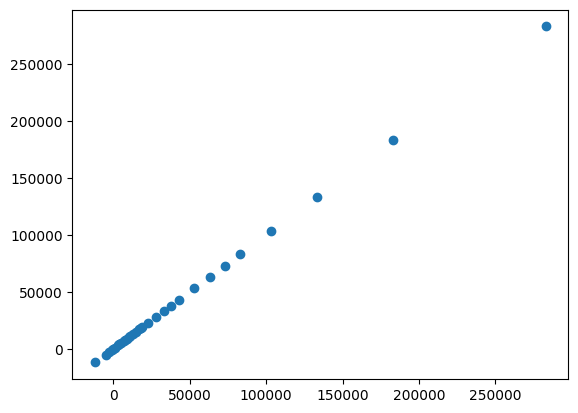

In [376]:
plt.scatter(result["x"], result["y"])

In [377]:
results = sm.ols(formula='y~x',data =result[["x", "y"]]).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.958e+11
Date:                Tue, 17 Jan 2023   Prob (F-statistic):          8.67e-149
Time:                        20:17:36   Log-Likelihood:                -36.419
No. Observations:                  32   AIC:                             76.84
Df Residuals:                      30   BIC:                             79.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0084      0.164     -0.051      0.959      -0.343       0.326
x              1.0000   2.26e-06   4.43e+05      0.000       1.000       1.000
==============================================================================
Omnibus:                        0.876   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.645   Jarque-Bera (JB):                0.874
Skew:                          -0.224   Prob(JB):                        0.646
Kurtosis:                       2.326   Cond. No.                     8.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""